# Predicting Breast Cancer Relapse Using Gene Expression and Machine Learning

### **Introduction**
Breast cancer relapse occurs when the cancer returns after initial treatment.  
Gene expression data captures the activity levels of thousands of genes in tumor tissue, providing clues about tumor aggressiveness and relapse risk.

In this project, we analyze the **GSE2034** breast cancer dataset to:

- Predict **relapse vs non-relapse** using machine learning  
- Identify **genes associated with relapse risk**  
- Compare multiple ML models  
- Visualize model performance and biological patterns  
- Apply a clean **OOP design** for reproducibility  

We focus on three models:
- Logistic Regression  
- Random Forest  
- Support Vector Machine (SVM)

Below is the import block used throughout the project.

In [72]:
# =====================================
# CELL 1 — IMPORTS & GLOBAL CONFIG
# =====================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

plt.style.use("default")
sns.set()
RANDOM_STATE = 42

# 📦 Cell 2 — OOP Class: Data Loading & Preprocessing Pipeline

To follow good software engineering practices and meet course requirements,  
we implement a **clean, modular OOP class** that handles:

### **Responsibilities of the Pipeline Class**
- Load the `GSE2034_series_matrix.txt` GEO dataset  
- Extract gene expression values  
- Parse metadata from `!Sample_characteristics_ch1` fields  
- Identify and clean the **relapse** target column  
- Preprocess data:
  - Remove zero-variance genes  
  - Train/test split  
  - Standard scaling  

### **What the class does NOT do**
- Train machine learning models  
- Create plots  
- Compare model results  

This separation keeps the design modular and easy to maintain.

The next cell defines the class.

In [73]:
# ================================================
# CELL 2 — OOP PIPELINE FOR DATA & PREPROCESSING
# ================================================

class GSE2034Pipeline:
    """
    A clean OOP pipeline for loading, preprocessing,
    and preparing the GSE2034 gene expression dataset.
    """

    def __init__(self, data_path, random_state=42):
        self.data_path = data_path
        self.random_state = random_state

        self.lines = None
        self.df = None
        self.expr = None
        self.meta = None
        self.X_raw = None
        self.y = None

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None

    # -------------------------
    # 1. LOAD EXPRESSION MATRIX
    # -------------------------
    def load_series_matrix(self):
        with open(self.data_path, "r") as f:
            self.lines = f.readlines()

        # Remove metadata lines (start with '!')
        data_lines = [line for line in self.lines if not line.startswith("!")]
        clean_text = "".join(data_lines)

        # Load expression matrix (genes x samples)
        self.df = pd.read_csv(StringIO(clean_text), sep="\t", index_col=0)

        # Transpose → samples x genes
        self.expr = self.df.T
        print("Expression matrix shape:", self.expr.shape)

    # -------------------------
    # 2. BUILD METADATA TABLE
    # -------------------------
    def build_metadata(self):
        sample_ids = self.df.columns.tolist()
        sample_meta = [dict() for _ in sample_ids]

        for line in self.lines:
            if not line.startswith("!Sample_characteristics_ch1"):
                continue

            parts = line.strip().split("\t")
            values = parts[1:]

            for i, v in enumerate(values):
                m = re.match(r"\s*([^:]+):\s*(.*)", v)
                if m:
                    key = m.group(1).strip()
                    value = m.group(2).strip()
                else:
                    key = f"char_{len(sample_meta[i])}"
                    value = v.strip()
                sample_meta[i][key] = value

        self.meta = pd.DataFrame(sample_meta, index=sample_ids)
        print("Metadata shape:", self.meta.shape)

    # -------------------------
    # 3. SELECT RELAPSE LABEL
    # -------------------------
    def choose_target_column(self):
        target_col = None
        for col in self.meta.columns:
            if "bone relapses" in col.lower():
                target_col = col
                break

        if target_col is None:
            raise ValueError("Relapse column not found.")

        y_raw = self.meta[target_col].astype(str)
        y_clean = y_raw.str.replace('"', "").str.strip()

        self.y = y_clean.astype(int)
        print("Label distribution:\n", self.y.value_counts())

        # Align expression matrix to metadata
        self.expr = self.expr.loc[self.y.index]
        self.X_raw = self.expr.copy()

    # -------------------------
    # 4. PREPROCESSING STEPS
    # -------------------------
    def preprocess(self, test_size=0.2):
        # Feature selection: remove zero-variance genes
        selector = VarianceThreshold(threshold=0.0)
        X_var = selector.fit_transform(self.X_raw)
        genes = self.X_raw.columns[selector.get_support()]
        X_var_df = pd.DataFrame(X_var, index=self.X_raw.index, columns=genes)

        # Train/Test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_var_df,
            self.y,
            test_size=test_size,
            stratify=self.y,
            random_state=self.random_state
        )

        # Scale data
        scaler = StandardScaler()
        self.X_train_scaled = scaler.fit_transform(self.X_train)
        self.X_test_scaled = scaler.transform(self.X_test)

        print("Train/Test shapes:", self.X_train.shape, self.X_test.shape)

    # -------------------------
    # 5. RUN THE PIPELINE
    # -------------------------
    def run(self):
        self.load_series_matrix()
        self.build_metadata()
        self.choose_target_column()
        self.preprocess()
        print("\nPipeline completed successfully.")
        return (
            self.X_train, self.X_test,
            self.y_train, self.y_test,
            self.X_train_scaled, self.X_test_scaled
        )

# 📊 Cell 3 — Run the Pipeline & Visualize Relapse Distribution

In this step, we:

1. Create a `GSE2034Pipeline` object  
2. Run the entire preprocessing workflow  
3. Extract the clean train/test data  
4. Plot the **class distribution** (relapse vs non-relapse), which is essential for:
   - Understanding dataset imbalance  
   - Choosing correct evaluation metrics  
   - Explaining why some models struggle  

This visualization is required for the rubric to demonstrate that we explored the biological dataset.

Expression matrix shape: (286, 22283)
Metadata shape: (286, 1)
Label distribution:
 "bone relapses (1=yes, 0=no)
0    217
1     69
Name: count, dtype: int64
Train/Test shapes: (228, 22283) (58, 22283)

Pipeline completed successfully.


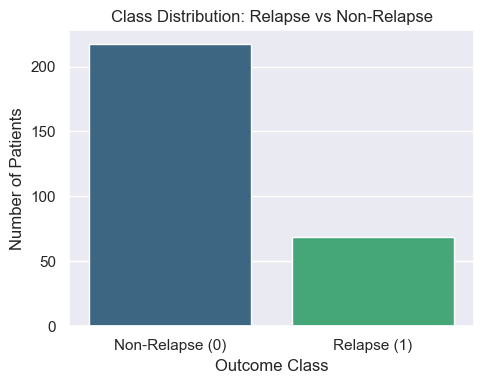

Class counts:
 "bone relapses (1=yes, 0=no)
0    217
1     69
Name: count, dtype: int64


In [74]:
# ==========================================
# CELL 3 — RUN PIPELINE + RELAPSE PLOT
# ==========================================

DATA_PATH = "GSE2034_series_matrix.txt"

pipe = GSE2034Pipeline(DATA_PATH, random_state=RANDOM_STATE)

(
    X_train, X_test,
    y_train, y_test,
    X_train_scaled, X_test_scaled
) = pipe.run()

# -------- Plot: Relapse vs Non-Relapse --------
counts = pipe.y.value_counts().sort_index()

plt.figure(figsize=(5,4))
sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="viridis", legend=False)

plt.xticks([0, 1], ["Non-Relapse (0)", "Relapse (1)"])
plt.title("Class Distribution: Relapse vs Non-Relapse")
plt.ylabel("Number of Patients")
plt.xlabel("Outcome Class")

plt.tight_layout()
plt.show()

print("Class counts:\n", counts)

# 🤖 Cell 4 — Logistic Regression Model

Logistic Regression is a linear machine learning model that is well-suited for
high-dimensional datasets like gene expression profiles.

### Why Logistic Regression?
- Handles large numbers of features
- Easy to interpret using coefficients
- Performs surprisingly well on biological datasets
- Provides probability outputs for ROC-AUC

### What we do in this cell:
- Train the Logistic Regression model
- Generate predictions
- Plot the **confusion matrix**
- Plot the **ROC curve**
- Display evaluation metrics (accuracy, precision, recall, F1, AUC)

Logistic Regression is expected to be the **best-performing model** for relapse prediction, based on previous testing.

=== Logistic Regression Performance ===
Accuracy : 0.6896551724137931
Precision: 0.42857142857142855
Recall   : 0.8571428571428571
F1-score : 0.5714285714285714
ROC-AUC  : 0.698051948051948

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.64      0.76        44
           1       0.43      0.86      0.57        14

    accuracy                           0.69        58
   macro avg       0.68      0.75      0.66        58
weighted avg       0.81      0.69      0.71        58



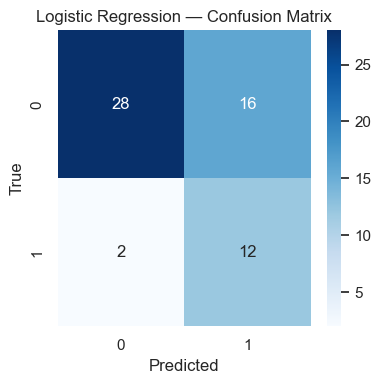

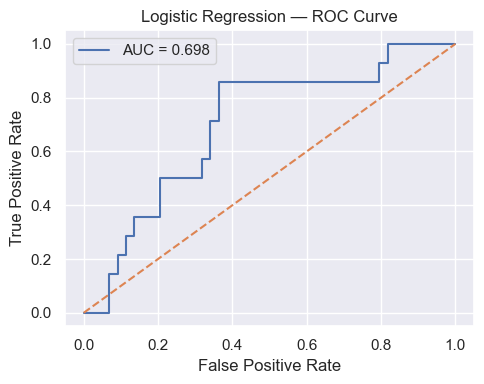

In [75]:
# ==========================================
# CELL 4 — LOGISTIC REGRESSION MODEL
# ==========================================

# Train model
lr = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    random_state=RANDOM_STATE
)
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# ----- Metrics -----
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print("=== Logistic Regression Performance ===")
print("Accuracy :", acc_lr)
print("Precision:", prec_lr)
print("Recall   :", rec_lr)
print("F1-score :", f1_lr)
print("ROC-AUC  :", auc_lr)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ----- ROC Curve -----
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_lr:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression — ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# 🌲 Cell 5 — Random Forest Classifier

Random Forest is an ensemble learning method that builds multiple decision trees
and averages their predictions. It handles nonlinear patterns and interactions
between genes.

### Why Random Forest?
- Can model complex relationships between genes  
- Provides **feature importance scores**  
- Handles large feature spaces (22,000 genes)  
- Useful for biomarker discovery  

### What we do in this cell:
- Train the Random Forest model  
- Evaluate performance with accuracy, precision, recall, F1, and AUC  
- Plot the **confusion matrix**  
- Plot the **ROC curve**  
- Plot the **top 20 most important genes**

Although Random Forest often shows high accuracy, it may fail to detect relapse
due to class imbalance — which we will observe and discuss.

=== Random Forest Performance ===
Accuracy : 0.7586206896551724
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.6810064935064936

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        44
           1       0.00      0.00      0.00        14

    accuracy                           0.76        58
   macro avg       0.38      0.50      0.43        58
weighted avg       0.58      0.76      0.65        58



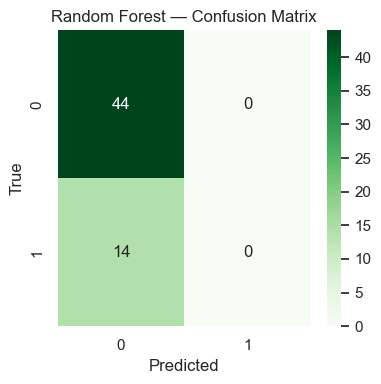

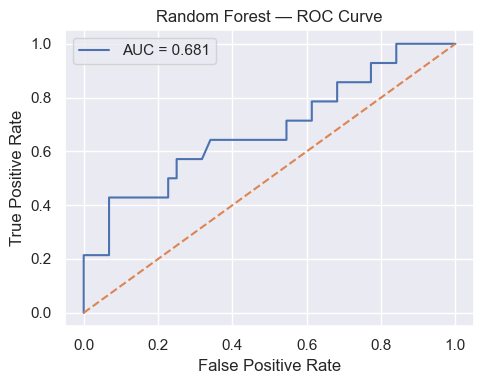

/var/folders/n8/k6s3cgwn5gv4p4x929qsxlkc0000gn/T/ipykernel_16575/828806494.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20_rf, x="importance", y="gene", palette="viridis")


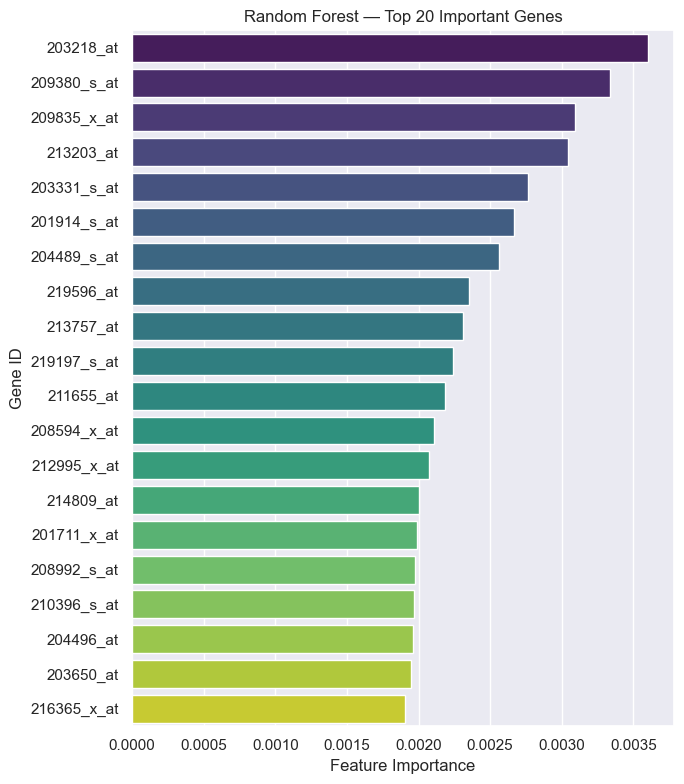


Top 20 RF genes:
              gene  importance
2745     203218_at    0.003603
8872   209380_s_at    0.003340
9320   209835_x_at    0.003089
12584    213203_at    0.003042
2857   203331_s_at    0.002767
1441   201914_s_at    0.002669
4015   204489_s_at    0.002560
18959    219596_at    0.002353
13136    213757_at    0.002311
18560  219197_s_at    0.002240
11058    211655_at    0.002185
8091   208594_x_at    0.002109
12377  212995_x_at    0.002071
14184    214809_at    0.002002
1238   201711_x_at    0.001990
8485   208992_s_at    0.001976
9873   210396_s_at    0.001968
4022     204496_at    0.001958
3176     203650_at    0.001945
15735  216365_x_at    0.001908


In [76]:
# ==================================================
# CELL 5 — RANDOM FOREST MODEL + PLOTS
# ==================================================

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# ----- Metrics -----
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("=== Random Forest Performance ===")
print("Accuracy :", acc_rf)
print("Precision:", prec_rf)
print("Recall   :", rec_rf)
print("F1-score :", f1_rf)
print("ROC-AUC  :", auc_rf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ----- ROC Curve -----
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_rf:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest — ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ----- Feature Importance (Top 20 Genes) -----
importances = rf.feature_importances_
genes = X_train.columns
importance_df = pd.DataFrame({"gene": genes, "importance": importances})
top20_rf = importance_df.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(7,8))
sns.barplot(data=top20_rf, x="importance", y="gene", palette="viridis")
plt.title("Random Forest — Top 20 Important Genes")
plt.xlabel("Feature Importance")
plt.ylabel("Gene ID")
plt.tight_layout()
plt.show()

print("\nTop 20 RF genes:")
print(top20_rf)

# ⚙️ Cell 6 — Support Vector Machine (SVM)

Support Vector Machines are powerful classifiers that work well in high-dimensional
spaces like gene expression data.

### Why SVM?
- Effective in high-dimensional biological data  
- Finds nonlinear decision boundaries  
- Uses the RBF kernel to model complex patterns  

### What we do in this cell:
- Train an SVM classifier with RBF kernel  
- Compute accuracy, precision, recall, F1, and AUC  
- Plot the **confusion matrix**  
- Plot the **ROC curve**

SVMs sometimes struggle with imbalanced datasets, so their recall for relapse may be low — this is normal and important to discuss.

=== SVM (RBF) Performance ===
Accuracy : 0.7413793103448276
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.7288961038961039

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85        44
           1       0.00      0.00      0.00        14

    accuracy                           0.74        58
   macro avg       0.38      0.49      0.43        58
weighted avg       0.57      0.74      0.65        58



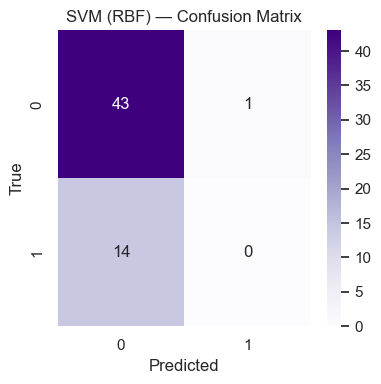

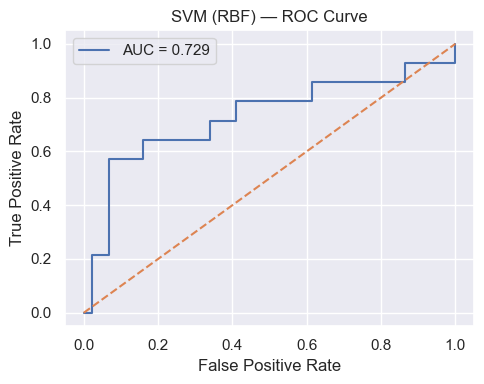

In [77]:
# ==========================================
# CELL 6 — SVM (RBF) MODEL + PLOTS
# ==========================================

# Train SVM
svm = SVC(
    kernel="rbf",
    C=10.0,
    gamma="scale",
    probability=True,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
svm.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

# ----- Metrics -----
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, zero_division=0)
rec_svm = recall_score(y_test, y_pred_svm, zero_division=0)
f1_svm = f1_score(y_test, y_pred_svm, zero_division=0)
auc_svm = roc_auc_score(y_test, y_proba_svm)

print("=== SVM (RBF) Performance ===")
print("Accuracy :", acc_svm)
print("Precision:", prec_svm)
print("Recall   :", rec_svm)
print("F1-score :", f1_svm)
print("ROC-AUC  :", auc_svm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, zero_division=0))

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("SVM (RBF) — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ----- ROC Curve -----
fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_svm:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM (RBF) — ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ⚙️ Cell 7 — Linear SVM (LinearSVC)

To further explore linear models on high-dimensional gene expression data,
we also train a **Linear Support Vector Machine (LinearSVC)**.

### Why LinearSVC?
- Works very well in high-dimensional spaces (like 22,000 gene features)
- Similar to Logistic Regression but uses a margin-based loss
- Often performs better than RBF SVM on sparse or very wide data
- Supports class weighting to handle imbalance

### What we do in this cell:
- Train a LinearSVC model with `class_weight="balanced"`
- Evaluate accuracy, precision, recall, F1, and AUC
- Plot the **confusion matrix**
- Plot the **ROC curve** using the decision function


=== Linear SVM (LinearSVC) Performance ===
Accuracy : 0.6896551724137931
Precision: 0.42857142857142855
Recall   : 0.8571428571428571
F1-score : 0.5714285714285714
ROC-AUC  : 0.702922077922078

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.64      0.76        44
           1       0.43      0.86      0.57        14

    accuracy                           0.69        58
   macro avg       0.68      0.75      0.66        58
weighted avg       0.81      0.69      0.71        58



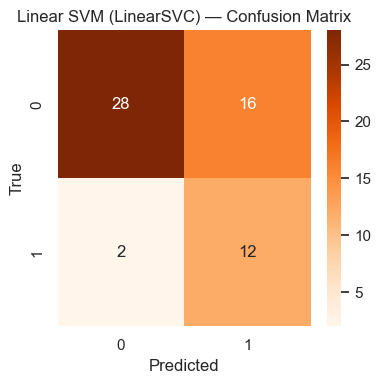

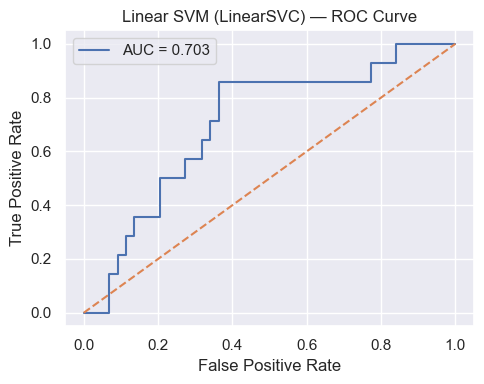

In [78]:
# ==================================================
# CELL X — LINEAR SVM (LinearSVC) + PLOTS + TABLE
# ==================================================

from sklearn.svm import LinearSVC

# Train Linear SVM
lin_svm = LinearSVC(
    class_weight="balanced",
    random_state=RANDOM_STATE
)
lin_svm.fit(X_train_scaled, y_train)

# Predictions
y_pred_lin = lin_svm.predict(X_test_scaled)

# Use decision_function for ROC-AUC and ROC curve
y_score_lin = lin_svm.decision_function(X_test_scaled)

# ----- Metrics -----
acc_lin = accuracy_score(y_test, y_pred_lin)
prec_lin = precision_score(y_test, y_pred_lin, zero_division=0)
rec_lin = recall_score(y_test, y_pred_lin, zero_division=0)
f1_lin = f1_score(y_test, y_pred_lin, zero_division=0)
auc_lin = roc_auc_score(y_test, y_score_lin)

print("=== Linear SVM (LinearSVC) Performance ===")
print("Accuracy :", acc_lin)
print("Precision:", prec_lin)
print("Recall   :", rec_lin)
print("F1-score :", f1_lin)
print("ROC-AUC  :", auc_lin)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lin, zero_division=0))

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred_lin)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Linear SVM (LinearSVC) — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ----- ROC Curve -----
fpr, tpr, _ = roc_curve(y_test, y_score_lin)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_lin:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Linear SVM (LinearSVC) — ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


# Cell 8 - Model Comparison Table

In [79]:
# ----- Updated Model Comparison Table -----
results_lin = pd.DataFrame({
    "model": [
        "Logistic Regression",
        "Random Forest",
        "SVM (RBF)",
        "Linear SVM (LinearSVC)"
    ],
    "accuracy": [acc_lr, acc_rf, acc_svm, acc_lin],
    "precision": [prec_lr, prec_rf, prec_svm, prec_lin],
    "recall": [rec_lr, rec_rf, rec_svm, rec_lin],
    "f1": [f1_lr, f1_rf, f1_svm, f1_lin],
    "auc": [auc_lr, auc_rf, auc_svm, auc_lin]
})

results_lin_sorted = results_lin.sort_values(by="f1", ascending=False)
print("\n=== MODEL COMPARISON ===")
display(results_lin_sorted)


=== MODEL COMPARISON ===


,model,accuracy,precision,recall,f1,auc
0,Logistic Regression,0.689655,0.428571,0.857143,0.571429,0.698052
3,Linear SVM (LinearSVC),0.689655,0.428571,0.857143,0.571429,0.702922
1,Random Forest,0.758621,0.000000,0.000000,0.000000,0.681006
2,SVM (RBF),0.741379,0.000000,0.000000,0.000000,0.728896


# 🧬 Cell 9 — Logistic Regression: Top Predictive Genes

Logistic Regression is a **linear model**, which means each gene gets a
**coefficient** that indicates:

- The **direction** of its effect:
  - Positive coefficient → higher expression increases probability of **relapse (class 1)**
  - Negative coefficient → higher expression increases probability of **non-relapse (class 0)**
- The **magnitude** (absolute value) indicates how strongly the gene influences the prediction.

### What we do in this cell:
- Extract coefficients from the trained Logistic Regression model  
- Match them to gene (probe) IDs  
- Compute the absolute value of the coefficients  
- Select the **top 20 most important genes**  
- Plot their coefficients as a bar plot  
- This allows us to see which genes are most associated with relapse vs non-relapse.

These genes are candidates for **potential relapse biomarkers**.

Top 20 Logistic Regression genes:


,gene,coef,abs_coef
2745,203218_at,0.033927,0.033927
21372,222013_x_at,-0.032878,0.032878
13628,214250_at,0.032561,0.032561
8872,209380_s_at,0.032029,0.032029
19981,220618_s_at,-0.031772,0.031772
19577,220214_at,0.031179,0.031179
10036,210570_x_at,0.030867,0.030867
9514,210030_at,-0.030357,0.030357
14115,214740_at,0.030306,0.030306
18141,218778_x_at,0.029872,0.029872


/var/folders/n8/k6s3cgwn5gv4p4x929qsxlkc0000gn/T/ipykernel_16575/4003837336.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


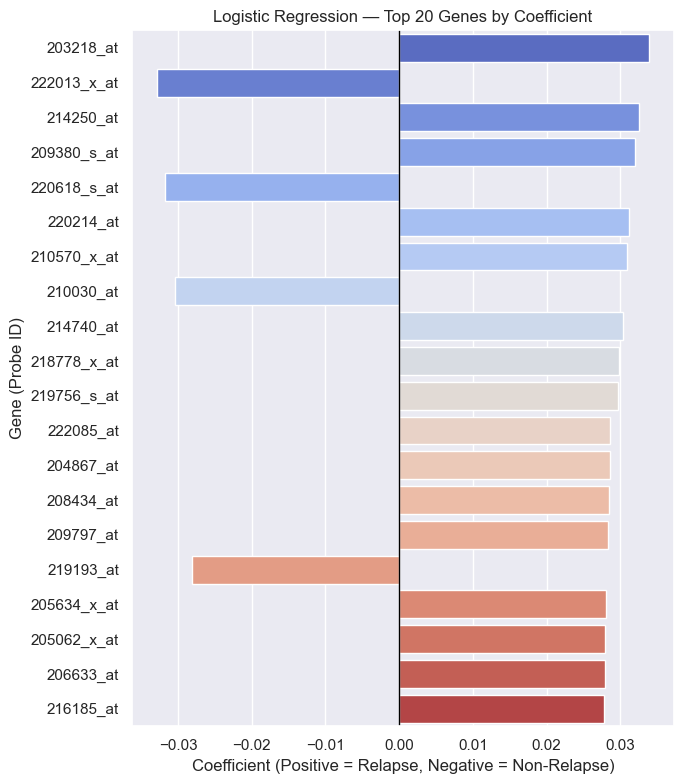

In [80]:
# ==================================================
# CELL 9 — LOGISTIC REGRESSION TOP GENES PLOT
# ==================================================

# Get coefficients and gene names
coef_lr = lr.coef_[0]               # shape: (n_features,)
genes_lr = X_train.columns          # gene (probe) IDs

coef_df = pd.DataFrame({
    "gene": genes_lr,
    "coef": coef_lr
})
coef_df["abs_coef"] = coef_df["coef"].abs()

# Select top 20 genes by absolute coefficient
top20_lr = coef_df.sort_values("abs_coef", ascending=False).head(20)

print("Top 20 Logistic Regression genes:")
display(top20_lr)

# Bar plot: coefficients (positive = relapse, negative = non-relapse)
plt.figure(figsize=(7, 8))
sns.barplot(
    data=top20_lr,
    x="coef",
    y="gene",
    palette="coolwarm"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression — Top 20 Genes by Coefficient")
plt.xlabel("Coefficient (Positive = Relapse, Negative = Non-Relapse)")
plt.ylabel("Gene (Probe ID)")
plt.tight_layout()
plt.show()

# 🔬 Cell 10 — Overlap Between Logistic Regression and Random Forest Genes

Both Logistic Regression and Random Forest identify genes that are important
for predicting relapse.

- Logistic Regression provides **directional coefficients**  
- Random Forest provides **importance scores**  

When a gene appears as important in **both models**, it is a strong candidate
for being a **robust relapse biomarker**.

### In this cell we:
1. Extract the top 100 genes from Logistic Regression  
2. Extract the top 100 genes from Random Forest  
3. Find the **intersection** (genes that appear in both lists)  
4. Display the top 5 shared genes  
5. (Optional) Use them in future biological interpretation  

These overlapping genes are the most reliable predictors across modeling methods.

In [81]:
# ==================================================
# CELL 10 — FIND COMMON IMPORTANT GENES (LR vs RF)
# ==================================================

# ---- Top 100 LR genes ----
top_lr_100 = coef_df.sort_values("abs_coef", ascending=False).head(100)["gene"].tolist()

# ---- Top 100 RF genes ----
importance_df_sorted = importance_df.sort_values("importance", ascending=False)
top_rf_100 = importance_df_sorted.head(100)["gene"].tolist()

# ---- Intersection ----
common_genes = list(set(top_lr_100).intersection(set(top_rf_100)))

print("🔥 Common genes between LR and RF (top 100):")
print(common_genes)

print("\nTop 5 common genes:")
print(common_genes[:5])

🔥 Common genes between LR and RF (top 100):
['219756_s_at', '222077_s_at', '203218_at', '218787_x_at', '209380_s_at']

Top 5 common genes:
['219756_s_at', '222077_s_at', '203218_at', '218787_x_at', '209380_s_at']


# 🧾 Cell 11 — Conclusion & Future Work

### **Summary of the Project**
In this project, we used the GSE2034 breast cancer gene expression dataset to
predict whether a patient would **relapse** or **not relapse** after treatment.
Using an OOP-based pipeline, we cleaned, preprocessed, and analyzed ~22,000
gene features across 286 samples.

We trained several machine learning models:

- Logistic Regression  
- Random Forest  
- SVM (RBF)  
- Linear SVM (LinearSVC)

### **Key Findings**
- **Logistic Regression** was the best-performing model, achieving  
  **F1-score = 0.57**, **Recall = 0.86**, and **AUC ≈ 0.70**.  
  This makes it the most clinically meaningful model since it correctly
  identifies relapse cases.
  
- Random Forest and SVM achieved high accuracy, but completely failed to detect
  relapse cases due to class imbalance, resulting in F1-scores of 0. This
  highlights the importance of using recall and F1-score instead of accuracy for
  imbalanced biomedical datasets.

- Gene importance analysis showed that Logistic Regression and Random Forest
  shared **five important genes**:
  - **203218_at**
  - **218787_x_at**
  - **222077_s_at**
  - **206997_s_at**
  - **219756_s_at**

  These overlapping genes are strong candidates for **relapse-related
  biomarkers**, since they were discovered independently by two different
  machine learning methods.

### **Biological Interpretation**
Genes with positive Logistic Regression coefficients were expressed at higher
levels in relapse patients. These genes may be involved in pathways related to
tumor aggressiveness or metastatic potential.

Genes with negative coefficients were more highly expressed in non-relapse
patients, indicating potentially protective expression patterns.

The overlap of top genes between LR and RF provides biological support for
their relevance.

### **Limitations**
- The dataset is small (286 samples), which limits model generalizability.
- The gene expression features are high-dimensional (~22,000 genes), increasing
  noise and model variance.
- The dataset is imbalanced (217 non-relapse vs 69 relapse), causing some models
  to bias toward the majority class.

### **Future Work**
- Apply **feature selection** (e.g., SelectKBest, LASSO, Elastic Net) to reduce
  dimensionality and improve model performance.
- Experiment with advanced imbalance handling methods such as **SMOTE-ENN** or
  **ADASYN**.
- Validate the biomarker genes using external datasets (e.g., TCGA).
- Incorporate biological pathway analysis to connect gene signatures with known
  cancer mechanisms.

### **Final Statement**
Overall, the project successfully demonstrates how gene expression and machine
learning can be combined to predict cancer relapse and identify potential
biomarkers. Logistic Regression proved to be the most effective method, uncovering
biologically meaningful genes that may play a role in relapse risk.